In [1]:
import numpy as np

from qiskit.quantum_info import Statevector, DensityMatrix, SuperOp, Operator, PTM

from qiskit_dynamics import Solver
from qiskit_dynamics.signals import Signal
from qiskit_dynamics.models import GeneratorModel

The aims of this PR are:
- Simplify `solve_lmde` and `solve_ode` to be as close as possible to `solve_ivp` style interface:
    - Input RHS functions take in/return arrays.
    - No input type-based inference, e.g. special handling of `Statevector`/`DensityMatrix`/`SuperOp`. This will purely treat things as functions and arrays, and if the functions can be evaluated on the input shape it will run.
        - One small exception here is: in `solve_lmde`, making sure the system is solved in the basis in which the frame is diagonal saves a lot of multiplications at each evaluation. I think this should be kept, and won't fully violate the above simplification principles.
- Add a high level `Solver` class which:
    - Directly takes in operators/signals and internally builds the right kind of model: either `HamiltonianModel` or `LindbladModel` depending on if dissipation is present.
    - `.solve` method which calls `solve_lmde` with the constructed model, but does a bunch of type handling and automatic decision making based on input types. E.g.
        - Conversion of `Statevector` -> `DensityMatrix` for dissipative dynamics.
        - Simulate unitary then compose if simulating a `SuperOp` without dissipative dynamics.
        - etc...
    - Exposes some setter methods for modifying the model, which overrides some of the setting in model.
        - E.g. if an RWA is done, there needs to be a mapping on signals, so the signal setter for `Solver` will automatically apply this mapping before passing to the model.


Currently: Some prototyping of the `Solver` has been done. Still need to start simplifying `solve_lmde` and `solve_ode`.

## 1. Simulate a Hamiltonian

Initialize the solver with only Hamiltonian information.

In [2]:
r = 0.5
w = 1.

ham_ops = [2 * np.pi * r * Operator.from_label('X') /2]
drift = 2 * np.pi * w * Operator.from_label('Z') /2

ham_solver = Solver(hamiltonian_operators=ham_ops,
                    hamiltonian_signals=[Signal(1., w)],
                    drift=drift,
                    rotating_frame=drift)

### 1.1 Passing arrays as initial states

The `solve` methods wraps `solve_lmde`, with some special handling depending on the state type. For initial states passed as arrays, they are fed directly to `solve_lmde` (i.e. no assumptions are made on what they are supposed to represent).

In [3]:
results = ham_solver.solve(t_span=[0., 2.], y0=np.array([0., 1.]), atol=1e-8, rtol=1e-8)
results.y[-1]

array([-1.0403078e-09-0.99796987j,  3.1073913e-03-0.06361181j])

### 1.2 Evolving density matrices without dissipation

We can pass an initial state as a `DensityMatrix`. Since there is only Hamiltonian information, `solve` first computes the unitary, then conjugates the density matrix to get the final state.

In [4]:
results2 = ham_solver.solve(t_span=[0., 2.], y0=DensityMatrix(np.array([0., 1.])), 
                            atol=1e-8, rtol=1e-8)
results2.y[-1]

DensityMatrix([[0.99594386+0.j        , 0.06348267-0.00310108j],
               [0.06348267+0.00310108j, 0.00405612+0.j        ]],
              dims=(2,))


These yield the same results:

In [5]:
np.outer(results.y[-1], results.y[-1].conj())

array([[0.99594386+0.j        , 0.06348267-0.00310108j],
       [0.06348267+0.00310108j, 0.00405612+0.j        ]])

### 1.3 Simulating `SuperOp`s

If the initial state is a quantum channel, it will compute the unitary and compose.

In [6]:
results3 = ham_solver.solve(t_span = [0., 2.], y0=SuperOp(np.eye(4, dtype=complex)),
                            atol=1e-8, rtol=1e-8)
PTM(results3.y[-1])

PTM([[ 9.99999975e-01+0.j,  0.00000000e+00+0.j,  0.00000000e+00+0.j,
       0.00000000e+00+0.j],
     [ 0.00000000e+00+0.j,  9.91907050e-01+0.j,  3.95335668e-04+0.j,
      -1.26965346e-01+0.j],
     [ 0.00000000e+00+0.j, -3.95331515e-04+0.j, -9.99980664e-01+0.j,
      -6.20216590e-03+0.j],
     [ 0.00000000e+00+0.j, -1.26965346e-01+0.j,  6.20216563e-03+0.j,
      -9.91887738e-01+0.j]],
    input_dims=(2,), output_dims=(2,))

Applying the final channel to the density matrix, we get the same output as the previous two calls (what's the right method?):

In [7]:
results3.y[-1]._evolve(DensityMatrix(np.array([0., 1.])))

DensityMatrix([[0.99594386+0.j        , 0.06348267-0.00310108j],
               [0.06348267+0.00310108j, 0.00405612+0.j        ]],
              dims=(2,))


## 2. Simulating the Lindblad equation

If dissipation operators are provided, internally the `Solver` constructs a `LindbladModel`.

In [8]:
r = 0.5
w = 1.

ham_ops = [2 * np.pi * r * Operator.from_label('X') /2]
drift = 2 * np.pi * w * Operator.from_label('Z') /2

diss_ops = [0.1 * np.array([[0., 0.], [1., 0.]])]

lindblad_solver = Solver(hamiltonian_operators=ham_ops,
                         hamiltonian_signals=[Signal(1., w)],
                         drift=drift,
                         rotating_frame=drift,#np.diag(np.array(drift)),
                         dissipator_operators=diss_ops)

Again, if a raw array is passed, no assumptions are made, and it tries to simulate.

Commented out because it raises error, but made a note here to highlight the design choice.

- Maybe should do some explicit validation of shapes/dimensions for all types?

In [9]:
results = lindblad_solver.solve(t_span=[0., 2.], y0=np.array([0., 1.]))

QiskitError: 'Shape mismatch for initial state y0 and LindbladModel.'

`Statevector`s are automatically converted to `DensityMatrix` instances before simulating.

In [10]:
results4 = lindblad_solver.solve(t_span=[0., 2.], y0=Statevector(np.array([0., 1.])),
                                atol=1e-8, rtol=1e-8)
results4.y[-1]

DensityMatrix([[0.9885849 +0.j        , 0.06206789-0.00943768j],
               [0.06206789+0.00943768j, 0.0114151 +0.j        ]],
              dims=(2,))


`SuperOp` simulation requires vectorizing the equation. If a user attempts to solve for a `SuperOp` without vectorizing, an error is raised:

In [11]:
results5 = lindblad_solver.solve(t_span = [0., 2.], y0=SuperOp(np.eye(4, dtype=complex)),
                                 atol=1e-8, rtol=1e-8)

QiskitError: 'Simulating SuperOp for a LinbladModel requires setting\n                vectorized evaluation. Set LindbladModel.evaluation_mode to a vectorized option.\n                '

The evaluation mode of the model can be accessed via the setter method of either the model contained in the solver, or via the solver's `set_evaluation_mode` method (which just calls the model's).

In [12]:
help(lindblad_solver.model.set_evaluation_mode)

Help on method set_evaluation_mode in module qiskit_dynamics.models.lindblad_models:

set_evaluation_mode(new_mode: str) method of qiskit_dynamics.models.lindblad_models.LindbladModel instance
    Sets evaluation mode.
    
    Args:
        new_mode: New mode for evaluation. Supported modes are:
            'dense': Stores Hamiltonian and dissipator terms as dense
                   Array types.
            'dense_vectorized': Stores the Hamiltonian and dissipator
                terms as (dim^2,dim^2) matrices that acts on a vectorized
                density matrix by left-multiplication. Allows for direct evaluate generator.
            'sparse': Like dense, but stores Hamiltonian components with
                `csr_matrix` types. Outputs will be dense if a 2d frame operator is
                used. Not compatible with jax.
            `sparse_vectorized': Like dense_vectorized, but stores everything as csr_matrices.
    Raises:
        NotImplementedError: If a mode other than on

In [13]:
# Copy/paste documentation here from model.set_evaluation_mode
# functools.wrap to copy doc strings?
lindblad_solver.model.set_evaluation_mode('dense_vectorized')
results5 = lindblad_solver.solve(t_span = [0., 2.], y0=SuperOp(np.eye(4, dtype=complex)),
                                 atol=1e-8, rtol=1e-8)
results5.y[-1]

SuperOp([[ 0.01141586+6.70213838e-18j, -0.06269332-3.06984253e-03j,
          -0.06269332+3.06984253e-03j,  0.9885849 +5.56384636e-17j],
         [-0.06331876+3.29798907e-03j, -0.00160054+1.39861888e-05j,
           0.98354069+4.79641171e-10j,  0.06206788+9.43767439e-03j],
         [-0.06331876-3.29798907e-03j,  0.98354069-4.79640992e-10j,
          -0.00160054-1.39861888e-05j,  0.06206788-9.43767439e-03j],
         [ 0.98858414-6.70213838e-18j,  0.06269332+3.06984253e-03j,
           0.06269332-3.06984253e-03j,  0.0114151 -5.56384636e-17j]],
        input_dims=(2,), output_dims=(2,))

In [14]:
results5.y[-1]._evolve(Statevector(np.array([0., 1.])))

DensityMatrix([[0.9885849 +5.56384636e-17j, 0.06206788-9.43767439e-03j],
               [0.06206788+9.43767439e-03j, 0.0114151 -5.56384636e-17j]],
              dims=(2,))


Once set to vectorized evaluation mode, we can still solve for `DensityMatrix` inputs, but it will do so by flattening/unflattening.

In [15]:
results6 = lindblad_solver.solve(t_span=[0., 2.], y0=Statevector(np.array([0., 1.])),
                                atol=1e-8, rtol=1e-8)
results6.y[-1]

DensityMatrix([[0.9885849 -5.93993015e-18j, 0.06206789-9.43767610e-03j],
               [0.06206789+9.43767610e-03j, 0.0114151 +5.93993015e-18j]],
              dims=(2,))


Array-vectorized operation. Here we can pass a list of arrays shaped appropriately for Lindblad model and they will solve simultaneously.

In [16]:
lindblad_solver.model.set_evaluation_mode('dense')
y0 = np.array([[[1., 0.], [0., 0.]], [[0., 0.], [0., 1.]]])
results7 = lindblad_solver.solve(t_span=[0., 2.], y0=y0,
                                atol=1e-8, rtol=1e-8)
results7.y[-1]

array([[[ 0.01141587+0.j        , -0.06331876-0.00329799j],
        [-0.06331876+0.00329799j,  0.98858413+0.j        ]],

       [[ 0.9885849 +0.j        ,  0.06206789-0.00943768j],
        [ 0.06206789+0.00943768j,  0.0114151 +0.j        ]]])

## 3. Rotating wave approxmation

RWA can be invoked at instantiation.

In [17]:
r = 0.5
w = 1.

ham_ops = [2 * np.pi * r * Operator.from_label('X') /2]
drift = 2 * np.pi * w * Operator.from_label('Z') /2

rwa_ham_solver = Solver(hamiltonian_operators=ham_ops,
                        hamiltonian_signals=[Signal(1., w)],
                        drift=drift,
                        rotating_frame=drift,
                        evaluation_mode='sparse',
                        rwa_cutoff_freq=2 * w)

Solving, we observe perfect inversion of the state once the RWA has been enacted.

In [18]:
results = rwa_ham_solver.solve(t_span=[0., 2.], y0=np.array([0., 1.]), atol=1e-8, rtol=1e-8)
results.y[-1]

array([-2.85423552e-16-1.00000000e+00j,  1.25527388e-09-3.39338479e-16j])

### 3.1 RWA signal convention

Current choice: 
- The `Solver` class stores its own internal `_signals`, which is whatever the user passed to either the constructor or set to the `signals` property - This is the case regardless of whether the RWA is being used or not.
- If no RWA, the same signals is passed directly to the model, but if RWA is present, when setting signals via the `Solver.signals` property, it will apply the RWA transformation before passing to the model.

I think maybe we should change the signal setters to full `set_signals` methods.

After RWA, the model actually stores two signals, one with the original phase and one with a phase shift. The `signal` property of the solver class reaches down to this.

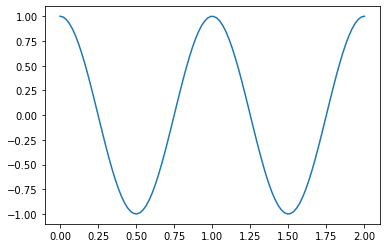

In [19]:
rwa_ham_solver.signals[0].draw(0, 2., 100)

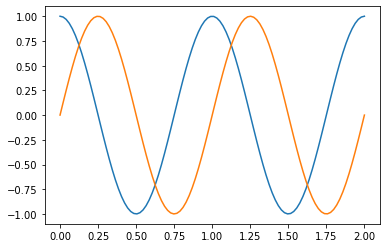

In [20]:
rwa_ham_solver.model.signals[0].draw(0, 2., 100)
rwa_ham_solver.model.signals[1].draw(0, 2., 100)

The signal setter for the `Solver` automatically performs the proper signal map before passing new signals to the model:

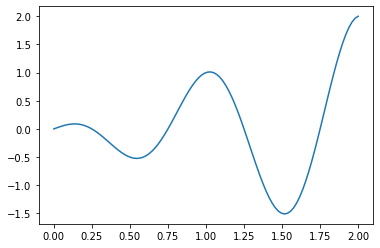

In [21]:
rwa_ham_solver.signals = [Signal(lambda t: t, w)]
rwa_ham_solver.signals[0].draw(0, 2., 100)

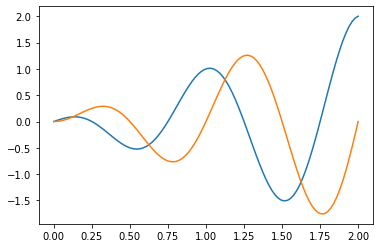

In [22]:
rwa_ham_solver.model.signals[0].draw(0, 2., 100)
rwa_ham_solver.model.signals[1].draw(0, 2., 100)